# Project Details:
# 1. Problem Statement:
Build a model to predict sales figures given other attributes of counterfeit medicine selling operations.
# 2. Data Files:
* counterfeit_train.csv: Contains training data with features and the target variable (sales figures).
* counterfeit_test.csv: Test data without the target variable. You need to predict and submit these sales figures in CSV format.
# 3.Evaluation Metric:
* The score is calculated as:
$$
\text{Score} = 1 - \left(\frac{\text{MAE}}{1660}\right)
$$,
where $MAE$ is the Mean Absolute Error.
* A score above 0.5 is required for project approval. Minimizing MAE is the focus.
# 4. Output Submission Requirements:
* Submit predictions in the exact format as sample_submission.csv.
* Column names, value types, and row counts must match the test data precisely.

# Importing Required Libraries

In [1]:
# 1. Initial Setup and Data Loading
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Loading the Datasets

In [2]:
# Load the datasets
train_data = pd.read_csv('data/counterfeit_train.csv')
test_data = pd.read_csv('data/counterfeit_test.csv')

# Dataset Overview:
* Inspect column names, data types, and missing values.
* Analyze basic statistics of numerical features.

In [4]:
train_data.head()

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales
0,RRA15,13.100,Area046,1995,160.2366,Antimalarial,critical,0.070422,DownTown,Tier 1,Small,1775.5026
1,YVV26,NaN,Area027,1983,110.4384,Mstablizers,mild,0.013000,CityLimits,Tier 3,Medium,3069.1520
2,LJC15,9.025,Area046,1995,259.4092,Cardiac,mild,0.060783,DownTown,Tier 1,Small,2603.0920
3,GWC40,11.800,Area046,1995,99.9830,OralContraceptives,mild,0.065555,DownTown,Tier 1,Small,1101.7130
4,QMN13,NaN,Area019,1983,56.4402,Hreplacements,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402


In [6]:
train_data.shape

(6818, 12)

In [7]:
train_data.columns

Index(['Medicine_ID', 'Counterfeit_Weight', 'DistArea_ID', 'Active_Since',
       'Medicine_MRP', 'Medicine_Type', 'SidEffect_Level',
       'Availability_rating', 'Area_Type', 'Area_City_Type', 'Area_dist_level',
       'Counterfeit_Sales'],
      dtype='object')

In [8]:
# EDA Step 1: Data Overview
print("\n--- Data Overview ---")
train_data.info()


--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6818 entries, 0 to 6817
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Medicine_ID          6818 non-null   object 
 1   Counterfeit_Weight   5652 non-null   float64
 2   DistArea_ID          6818 non-null   object 
 3   Active_Since         6818 non-null   int64  
 4   Medicine_MRP         6818 non-null   float64
 5   Medicine_Type        6818 non-null   object 
 6   SidEffect_Level      6818 non-null   object 
 7   Availability_rating  6818 non-null   float64
 8   Area_Type            6818 non-null   object 
 9   Area_City_Type       6818 non-null   object 
 10  Area_dist_level      6818 non-null   object 
 11  Counterfeit_Sales    6818 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 639.3+ KB


In [9]:
numeric_columns = train_data.select_dtypes(exclude=['object']).columns.tolist()
print('The Numeric Columns in the Counterfeit Dataset are:')
print(numeric_columns)

categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()
print('The Categorical Columns in the Counterfeit Dataset are:')
print(categorical_columns)

The Numeric Columns in the Counterfeit Dataset are:
['Counterfeit_Weight', 'Active_Since', 'Medicine_MRP', 'Availability_rating', 'Counterfeit_Sales']
The Categorical Columns in the Counterfeit Dataset are:
['Medicine_ID', 'DistArea_ID', 'Medicine_Type', 'SidEffect_Level', 'Area_Type', 'Area_City_Type', 'Area_dist_level']


In [10]:
print("\n--- Statistical Summary ---")
train_data.describe().T


--- Statistical Summary ---


,count,mean,std,min,25%,50%,75%,max
Counterfeit_Weight,5652.0,14.115057,4.649668,5.855,9.995000,13.800000,18.050000,22.650000
Active_Since,6818.0,1995.836316,8.368979,1983.000,1985.000000,1997.000000,2002.000000,2007.000000
Medicine_MRP,6818.0,151.401518,62.203961,41.790,104.509400,153.195700,196.148350,277.188400
Availability_rating,6818.0,0.079174,0.051481,0.013,0.040058,0.066955,0.107697,0.341391
Counterfeit_Sales,6818.0,2280.583480,1693.354404,146.290,933.265600,1902.670400,3207.638400,13199.964800


In [11]:
train_data.describe(include=['O'])

,Medicine_ID,DistArea_ID,Medicine_Type,SidEffect_Level,Area_Type,Area_City_Type,Area_dist_level
count,6818,6818,6818,6818,6818,6818,6818
unique,1557,10,16,2,4,3,4
top,RQS74,Area017,Hreplacements,mild,DownTown,Tier 3,Medium
freq,9,760,976,4434,4481,2655,2203


1. Training Data (counterfeit_train.csv):
* Contains features such as Medicine_ID, Counterfeit_Weight, DistArea_ID, Active_Since, Medicine_MRP, and more.
* Target variable: Counterfeit_Sales.
2. Test Data (counterfeit_test.csv):
* Similar structure to training data but excludes the Counterfeit_Sales column.
* The goal is to predict Counterfeit_Sales for the test dataset.

Key Observations:
* There are numerical and categorical features.
* Missing values exist (e.g., Counterfeit_Weight).
* Potential categorical features: Medicine_Type, SidEffect_Level, Area_Type, etc.
* Numerical features like Medicine_MRP, Availability_rating, and Counterfeit_Weight will likely be significant for modeling.

**Checking for Null values in the Data**

In [12]:
train_data.isnull().sum()

Medicine_ID               0
Counterfeit_Weight     1166
DistArea_ID               0
Active_Since              0
Medicine_MRP              0
Medicine_Type             0
SidEffect_Level           0
Availability_rating       0
Area_Type                 0
Area_City_Type            0
Area_dist_level           0
Counterfeit_Sales         0
dtype: int64

In [13]:
train_data.isnull().any()

Medicine_ID            False
Counterfeit_Weight      True
DistArea_ID            False
Active_Since           False
Medicine_MRP           False
Medicine_Type          False
SidEffect_Level        False
Availability_rating    False
Area_Type              False
Area_City_Type         False
Area_dist_level        False
Counterfeit_Sales      False
dtype: bool

In [14]:
# EDA Step 2: Missing Values Analysis
missing_values = train_data.isnull().sum()
print("\n--- Missing Values in Train Data ---")
print(missing_values[missing_values > 0])

missing_values = test_data.isnull().sum()
print("\n--- Missing Values in Test Data ---")
print(missing_values[missing_values > 0])


--- Missing Values in Train Data ---
Counterfeit_Weight    1166
dtype: int64

--- Missing Values in Test Data ---
Counterfeit_Weight    297
dtype: int64


In [15]:
train_data.head(10)

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales
0,RRA15,13.100,Area046,1995,160.2366,Antimalarial,critical,0.070422,DownTown,Tier 1,Small,1775.5026
1,YVV26,NaN,Area027,1983,110.4384,Mstablizers,mild,0.013000,CityLimits,Tier 3,Medium,3069.1520
2,LJC15,9.025,Area046,1995,259.4092,Cardiac,mild,0.060783,DownTown,Tier 1,Small,2603.0920
3,GWC40,11.800,Area046,1995,99.9830,OralContraceptives,mild,0.065555,DownTown,Tier 1,Small,1101.7130
4,QMN13,NaN,Area019,1983,56.4402,Hreplacements,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402
5,JDG81,8.775,Area045,2000,165.5656,Antiseptics,mild,0.088881,DownTown,Tier 2,Unknown,3047.8464
6,KPX48,18.000,Area018,2007,156.9102,Hreplacements,critical,0.051685,Industrial,Tier 3,Medium,2883.3938
7,CYW14,7.680,Area013,1985,154.3470,Antiseptics,mild,0.028150,DownTown,Tier 3,High,3262.2340
8,TVF57,18.550,Area046,1995,107.3068,Hreplacements,critical,0.060266,DownTown,Tier 1,Small,1959.9292
9,MGU75,9.510,Area013,1985,161.1392,Statins,mild,0.023755,DownTown,Tier 3,High,3095.7840


In [16]:
train_data.tail(10)

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales
6808,JUL12,20.650,Area017,2005,123.0518,Hreplacements,critical,0.090193,DownTown,Tier 2,Unknown,796.1108
6809,JKR96,12.650,Area046,1995,98.2856,Antipyretics,critical,0.076226,DownTown,Tier 1,Small,1607.0552
6810,YED13,16.100,Area018,2007,119.3570,Antacids,critical,0.057072,Industrial,Tier 3,Medium,1541.1410
6811,VVO38,NaN,Area019,1983,102.1120,Antipyretics,mild,0.074393,MidTownResidential,Tier 1,Small,485.8480
6812,XWX56,17.650,Area010,1996,135.1020,Antiseptics,mild,0.071034,MidTownResidential,Tier 3,Unknown,366.0040
6813,OYN80,8.535,Area046,1995,204.1452,Hreplacements,mild,0.112963,DownTown,Tier 1,Small,2070.4520
6814,ACW12,20.650,Area046,1995,235.1088,Hreplacements,mild,0.131103,DownTown,Tier 1,Small,2126.3792
6815,OPM10,20.000,Area017,2005,193.6292,Antimalarial,critical,0.105096,DownTown,Tier 2,Unknown,2119.7212
6816,SLY12,10.180,Area045,2000,162.8682,Statins,mild,0.099957,DownTown,Tier 2,Unknown,1485.2138
6817,ATT10,7.930,Area018,2007,177.5500,Mstablizers,critical,0.117445,Industrial,Tier 3,Medium,1943.9500


In [17]:
test_data.head(10)

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level
0,HLZ81,NaN,Area027,1983,85.5328,Antibiotics,mild,0.112747,CityLimits,Tier 3,Medium
1,ECE94,13.45,Area045,2000,257.1460,OralContraceptives,mild,0.144446,DownTown,Tier 2,Unknown
2,SAD14,7.10,Area045,2000,98.1172,Antipyretics,mild,0.144221,DownTown,Tier 2,Unknown
3,EQV63,18.30,Area010,1996,135.3730,Tranquilizers,mild,0.100388,MidTownResidential,Tier 3,Unknown
4,AIR10,NaN,Area019,1983,112.8016,OralContraceptives,mild,0.022585,MidTownResidential,Tier 1,Small
5,LIC37,14.45,Area010,1996,190.2976,OralContraceptives,mild,0.074382,MidTownResidential,Tier 3,Unknown
6,EXZ14,NaN,Area027,1983,163.3656,OralContraceptives,critical,0.073134,CityLimits,Tier 3,Medium
7,UCB79,17.15,Area046,1995,226.9166,Antacids,mild,0.082101,DownTown,Tier 1,Small
8,IDJ12,NaN,Area027,1983,225.0534,OralContraceptives,mild,0.094614,CityLimits,Tier 3,Medium
9,KLQ71,15.10,Area045,2000,101.0172,Cardiac,critical,0.027763,DownTown,Tier 2,Unknown


In [18]:
test_data.tail(10)

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level
1695,TTJ13,21.50,Area046,1995,104.8752,Hreplacements,critical,0.134254,DownTown,Tier 1,Small
1696,GSV13,13.65,Area013,1985,122.5518,Antibiotics,mild,0.112675,DownTown,Tier 3,High
1697,ZXN29,10.90,Area049,1997,111.9990,Antacids,critical,0.013000,DownTown,Tier 1,Medium
1698,RTV34,16.50,Area013,1985,249.0248,Hreplacements,mild,0.032019,DownTown,Tier 3,High
1699,VFE97,17.40,Area010,1996,264.0356,Antibiotics,mild,0.070423,MidTownResidential,Tier 3,Unknown
1700,KXW10,NaN,Area027,1983,136.5704,Hreplacements,mild,0.050505,CityLimits,Tier 3,Medium
1701,CKE54,21.30,Area035,2002,57.0744,Antibiotics,critical,0.041118,DownTown,Tier 2,Small
1702,HAY13,20.40,Area017,2005,182.7422,Antiseptics,mild,0.191273,DownTown,Tier 2,Unknown
1703,ZEE32,20.00,Area018,2007,266.9672,Hreplacements,mild,0.013000,Industrial,Tier 3,Medium
1704,NDL93,8.08,Area045,2000,238.7694,Antibiotics,critical,0.098982,DownTown,Tier 2,Unknown


# Visualization
* Distribution of numerical features.
* Counts of categorical features.
* Correlation heatmap for numerical variables.

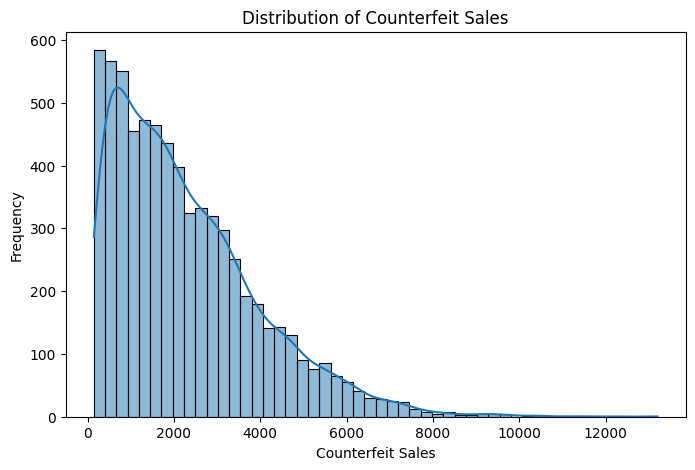

In [19]:
# Distribution of Counterfeit Sales
plt.figure(figsize=(8, 5))
sns.histplot(train_data['Counterfeit_Sales'], bins=50, kde=True)
plt.title("Distribution of Counterfeit Sales")
plt.xlabel("Counterfeit Sales")
plt.ylabel("Frequency")
plt.show()

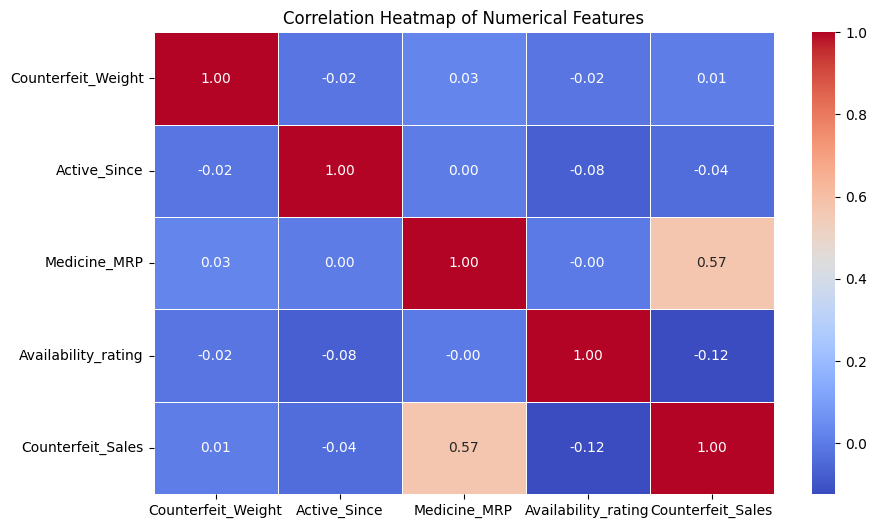

In [20]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
numeric_data = train_data.select_dtypes(include=['number'])
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [21]:
train_data.dtypes

Medicine_ID             object
Counterfeit_Weight     float64
DistArea_ID             object
Active_Since             int64
Medicine_MRP           float64
Medicine_Type           object
SidEffect_Level         object
Availability_rating    float64
Area_Type               object
Area_City_Type          object
Area_dist_level         object
Counterfeit_Sales      float64
dtype: object

In [22]:
# IQR Method for Outlier Detection and Removal
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [23]:
# Removing outliers from numerical columns
numerical_cols = ['Counterfeit_Weight', 'Medicine_MRP', 'Availability_rating', 'Counterfeit_Sales']
for col in numerical_cols:
    train_data = remove_outliers(train_data, col)

**Step 1: Identify Outliers Using Boxplots**
* This step uses `sns.boxplot` to visualize how the categorical features relate to the target variable (`Counterfeit_Sales`).
* Outliers: Observed as points outside the whiskers of the boxplot.

**Step 2: Detect Outliers**

* **Quantile Calculation:**
    * `Q1` and `Q3` represent the 25th and 75th percentiles of the target column, respectively.
    * The IQR (Interquartile Range) is the difference between `Q3` and `Q1`.

* **Lower and Upper Boundaries:**
    * Lower: `Q1 - 1.5 * IQR`
    * Upper: `Q3 + 1.5 * IQR`
    * These boundaries are used to detect outliers.

**Step 3: Filter Out Outliers**
* Use boolean indexing to retain only rows where the target variable (`Counterfeit_Sales`) lies within the lower and upper bounds.
* This creates a new dataset (`train_data_no_outliers`) without outliers.

**Step 4: Visualize Again**
* Re-plot the boxplots after outlier removal to confirm that extreme values are no longer present.


**Steps to Remove Outliers:**

* Use IQR (Interquartile Range) method to detect and remove outliers for numerical columns.
* For categorical features, outliers might appear as rare or unusual values, which can also be filtered.

**Why Use IQR?**
* The IQR method is robust against skewed data and avoids assumptions about the data's distribution (unlike Z-scores).

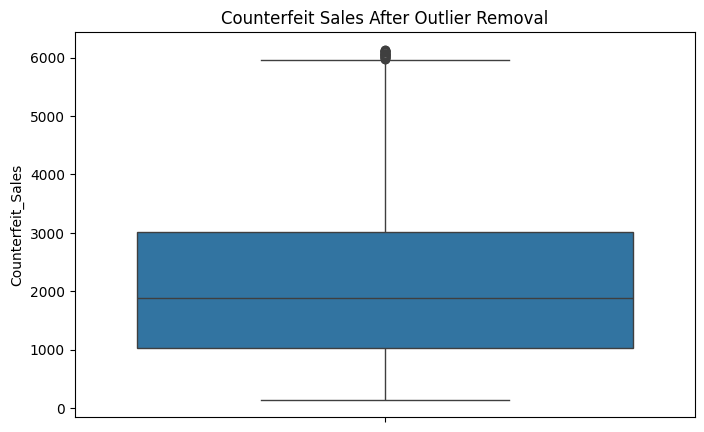

In [24]:
# Visualizing Data After Removing Outliers
plt.figure(figsize=(8, 5))
sns.boxplot(y=train_data['Counterfeit_Sales'])
plt.title("Counterfeit Sales After Outlier Removal")
plt.show()

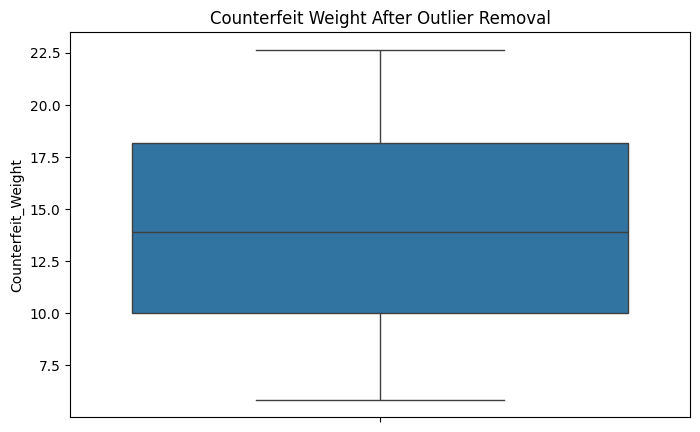

In [25]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=train_data['Counterfeit_Weight'])
plt.title("Counterfeit Weight After Outlier Removal")
plt.show()

In [26]:
# Ensure only numeric columns are used for correlation calculation
numeric_columns = train_data.select_dtypes(include=[np.number]).columns.tolist()

# Correlation between Target and Other Features
correlation_with_target = train_data[numeric_columns].corr()["Counterfeit_Sales"].sort_values(ascending=False)
print("Correlation with Counterfeit Sales:\n", correlation_with_target)

Correlation with Counterfeit Sales:
 Counterfeit_Sales      1.000000
Medicine_MRP           0.618763
Active_Since           0.017657
Counterfeit_Weight     0.011020
Availability_rating   -0.043684
Name: Counterfeit_Sales, dtype: float64


In [27]:
# 3. Data Preprocessing
# Handle missing values in Counterfeit_Weight using Median (Recommended Approach)
median_weight = train_data['Counterfeit_Weight'].median()
train_data['Counterfeit_Weight'].fillna(median_weight, inplace=True)
test_data['Counterfeit_Weight'].fillna(median_weight, inplace=True)

C:\Users\D MADHAN MOHAN\AppData\Local\Temp\ipykernel_31384\1751426485.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Counterfeit_Weight'].fillna(median_weight, inplace=True)
C:\Users\D MADHAN MOHAN\AppData\Local\Temp\ipykernel_31384\1751426485.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [28]:
# Encode categorical variables using Label Encoding
categorical_cols = ['DistArea_ID', 'Medicine_Type', 'SidEffect_Level', 'Area_Type', 'Area_City_Type', 'Area_dist_level']
label_encoders = {}

In [29]:
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    # Handle unseen labels in test data by using fit classes
    test_data[col] = test_data[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_encoders[col] = le

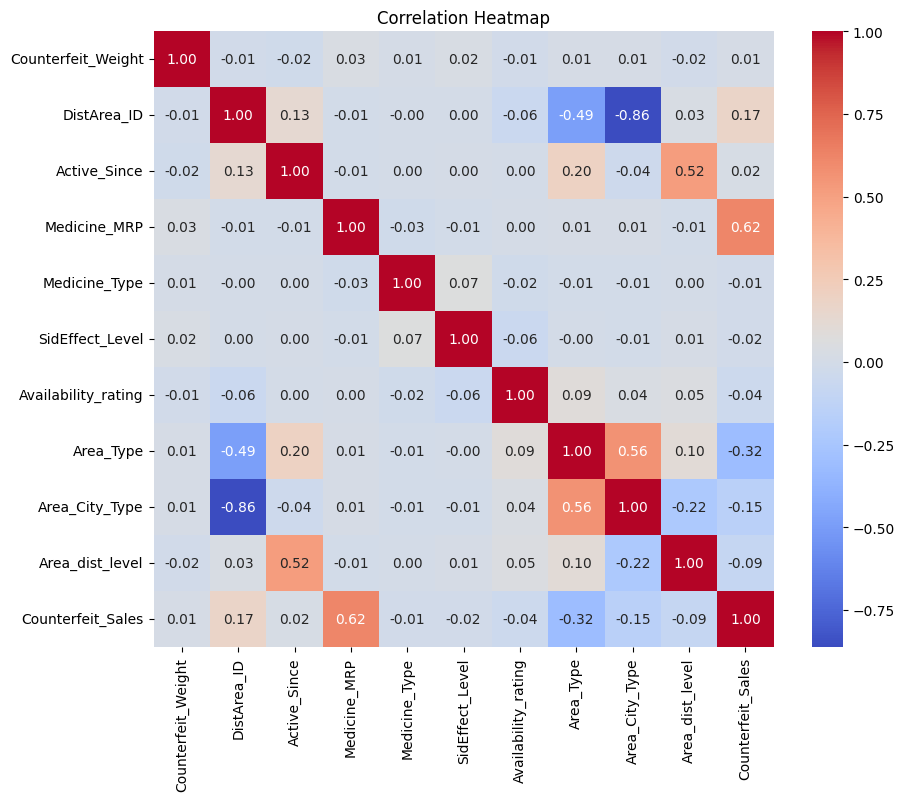

In [30]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
# Exclude 'Medicine_ID' from correlation calculation
correlation = train_data.drop(columns=['Medicine_ID']).corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**The correlation heatmap identifies relationships between numerical variables, helping you detect multicollinearity or highly correlated features.**

# Model Training & Model Evaluation

In [31]:
# 4. Model Training
# Define feature columns
feature_columns = [col for col in train_data.columns if col not in ['Counterfeit_Sales', 'Medicine_ID']]

In [32]:
# Prepare training data
X = train_data[feature_columns]
y = train_data['Counterfeit_Sales']

In [33]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Hyperparameter Tuning for XGBoost
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

In [35]:
# Best Model
best_xgb = grid_search.best_estimator_
y_val_pred = best_xgb.predict(X_val)

In [36]:
# Evaluate model performance
mae = mean_absolute_error(y_val, y_val_pred)
score = 1 - (mae / 1660)
print(f"Best Model MAE: {mae}, Score: {score}")

Best Model MAE: 709.4704146360971, Score: 0.5726081839541584


In [37]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [38]:
# Predict on validation set
y_val_pred = model.predict(X_val)

In [39]:
# Evaluate model performance
mae = mean_absolute_error(y_val, y_val_pred)
score = 1 - (mae / 1660)
print(f"MAE: {mae}, Score: {score}")

MAE: 731.1092254990892, Score: 0.5595727557234402


In [40]:
# 5. Prediction and Final Submission
X_test = test_data[feature_columns]
test_predictions = best_xgb.predict(X_test)

In [44]:
test_data['Counterfeit_Sales'] = test_predictions
predictions_output_path = "D:/DataScience_Projects/Counterfeit Medicines Sales Prediction/counterfeit_sales_predictions.csv"
test_data[['Medicine_ID', 'Counterfeit_Sales']].to_csv(predictions_output_path, index=False)

print(f"Predictions saved to: {predictions_output_path}")

Predictions saved to: D:/DataScience_Projects/Counterfeit Medicines Sales Prediction/counterfeit_sales_predictions.csv
